# Lorenz attractor — Ensemble Kalman filter

we show how easy is to extend our method to other filtering algorithms.

In [1]:
import jax
import chex
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from rebayes_mini import callbacks
from rebayes_mini.methods import ensemble_kalman_filter as enkf

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18
cmap = {
    "ANN-1": "crimson",
    "WLF-IMQ": "dodgerblue",
    "KF": "lightseagreen",
    "WLF-MD": "gold",
}

In [3]:
def rk4_step(y, i, dt, f):
    h = dt
    t = dt * i
    k1 = h * f(y, t)
    k2 = h * f(y + k1 / 2, dt * i + h / 2)
    k3 = h * f(y + k2 / 2, t + h / 2)
    k4 = h * f(y + k3, t + h)

    y_next = y + 1 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return y_next

    

@partial(jax.jit, static_argnames=("f",))
def rk4(ys, dt, N, f):
    """
    Based on
    https://colab.research.google.com
    github/google/jax/blob/master/cloud_tpu_colabs/Lorentz_ODE_Solver
    """
    @jax.jit
    def step(i, ys):
        ysi = rk4_step(ys[i - 1], i, dt, f)
        return ys.at[i].set(ysi)
    return jax.lax.fori_loop(1, N, step, ys)

## 3D Lorenz

In [4]:
sigma = 10.
beta = 8./3
rho = 28.


def f(state, t):
    x, y, z = state
    xdot = sigma * (y - x)
    ydot = x * (rho - z) - y
    zdot = x * y - beta * z
    return jnp.array([xdot, ydot, zdot])

y0 = jnp.ones(3)
N = 5_000
ys = jnp.zeros((N,) + y0.shape)
ys = ys.at[0].set(y0)
res = rk4(ys, 0.004, N, f)

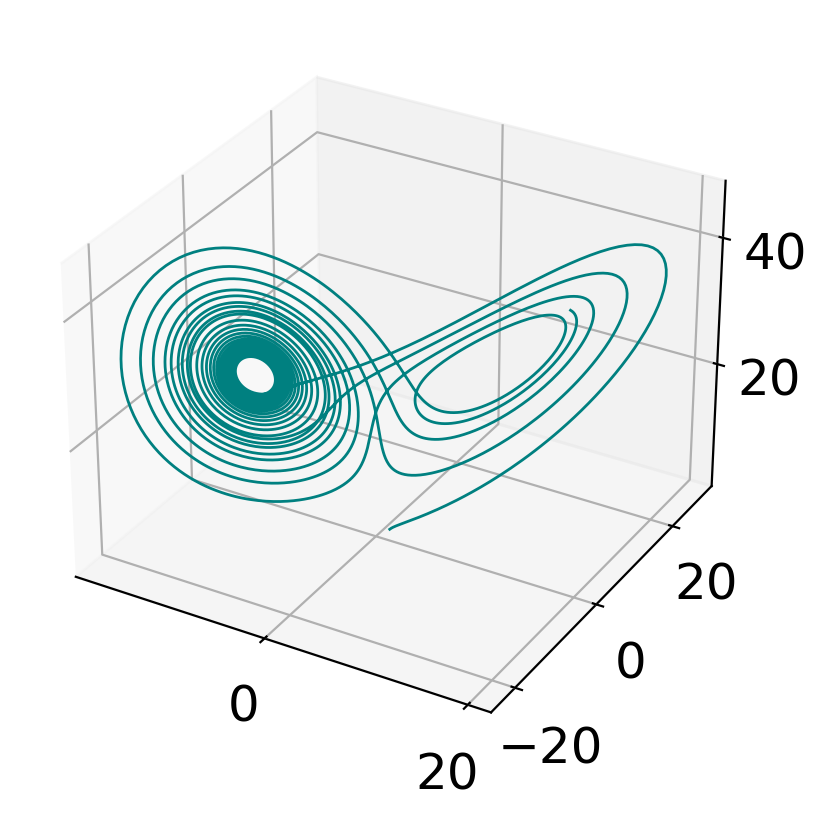

In [5]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*res.T, lw=1.0, c="teal")

# Modified Lorenz 96 model
See https://en.wikipedia.org/wiki/Lorenz_96_model


$$
    \dot{\bf x}_k = \Big({\bf x}_{k+1} - {\bf x}_{k-2}\Big) {\bf x}_{j-1} - {\bf x}(j) + {F}_k
$$
with 
* $F_k \sim {\cal N}(8, 1)$

In [6]:
D = 40
F = 8.0
# ixs = jnp.arange(D)

key = jax.random.PRNGKey(31415)
key_init, key_sim, key_eval = jax.random.split(key, 3)
x0 = jax.random.normal(key_init, (D,)) + F

key_state, key_measurement = jax.random.split(key_sim)

In [7]:
@partial(jax.vmap, in_axes=(None, 0, None))
def fcoord(x, k, D):
    xdot = (x[(k + 1) % D] - x[k - 2]) * x[k - 1] - x[k] + F
    return xdot

def f(x, t, D, *args):
    keyt = jax.random.fold_in(key_state, t)
    err = jax.random.normal(keyt, shape=(D,))
    ixs = jnp.arange(D)
    xdot = fcoord(x, ixs, D) + F + err
    return xdot

In [8]:
N = 60
dt = 0.05
xs = jnp.zeros((N,) + x0.shape)
xs = xs.at[0].set(x0)
fpart = partial(f, D=D)
xs = rk4(xs, dt, N, fpart)
ys = xs + jax.random.normal(key_measurement, xs.shape)

In [9]:
ys_corrupted = ys.copy()
p_err = 0.01
errs_map = jax.random.bernoulli(key_init, p=p_err, shape=ys_corrupted.shape)
ys_corrupted = ys_corrupted * (~errs_map) + 100.0 * errs_map
err_where = np.where(errs_map)

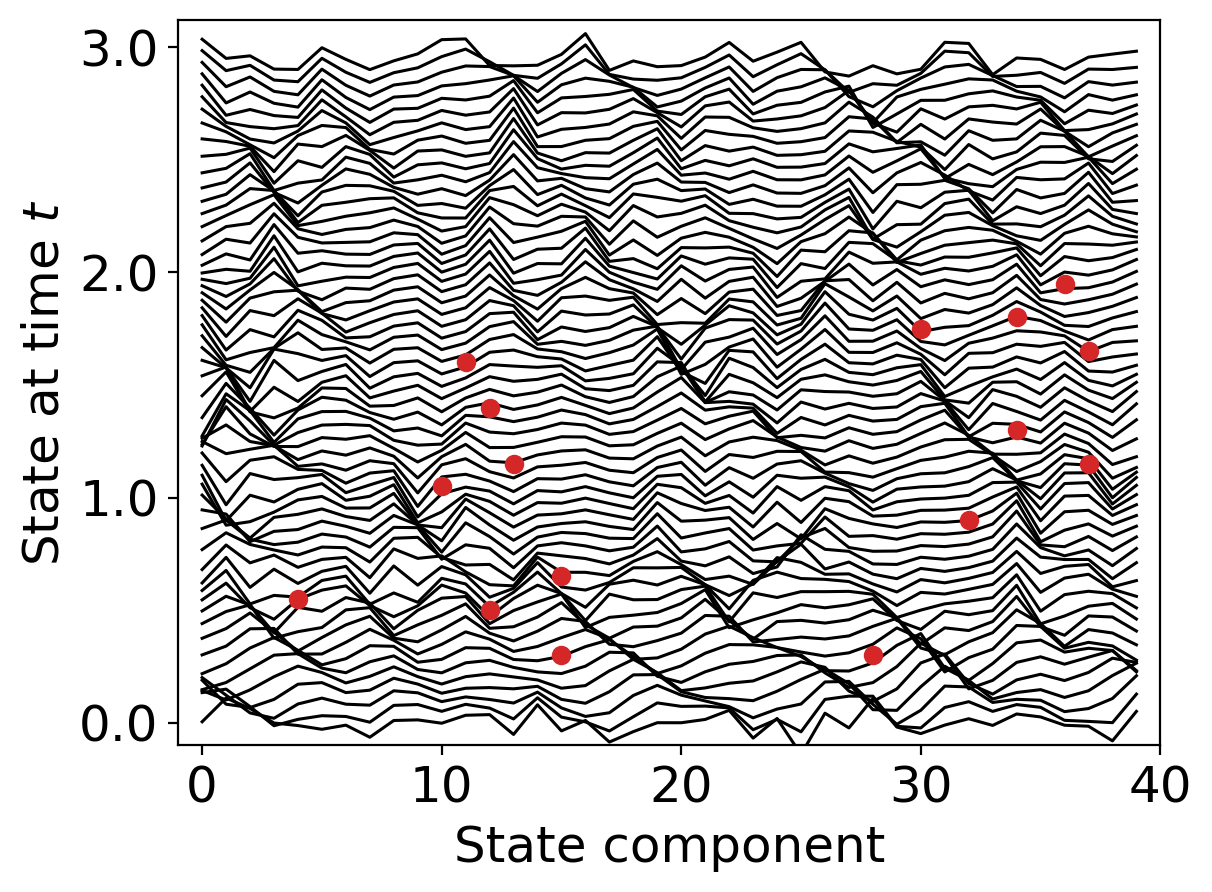

In [10]:
xs_cpu = np.array(xs)
for n, row in enumerate(xs):
    # plt.axhline(y=n, c="tab:gray", zorder=1, alpha=0.2)
    plt.plot((row - row.mean()) / row.std() + n, c="black", zorder=1, linewidth=1.1)
plt.xlabel("State component")
plt.ylabel("State at time $t$")
pos, vals = plt.yticks()
plt.yticks(pos[1:-1], pos[1:-1] * dt);
plt.ylim(bottom=pos[1] - 2, top=pos[-2] * 1.04)
plt.xlim(-1, D)
plt.scatter(*err_where, c="tab:red")

plt.tight_layout()
plt.savefig("./figures/lorenz96-waves.png", dpi=300)

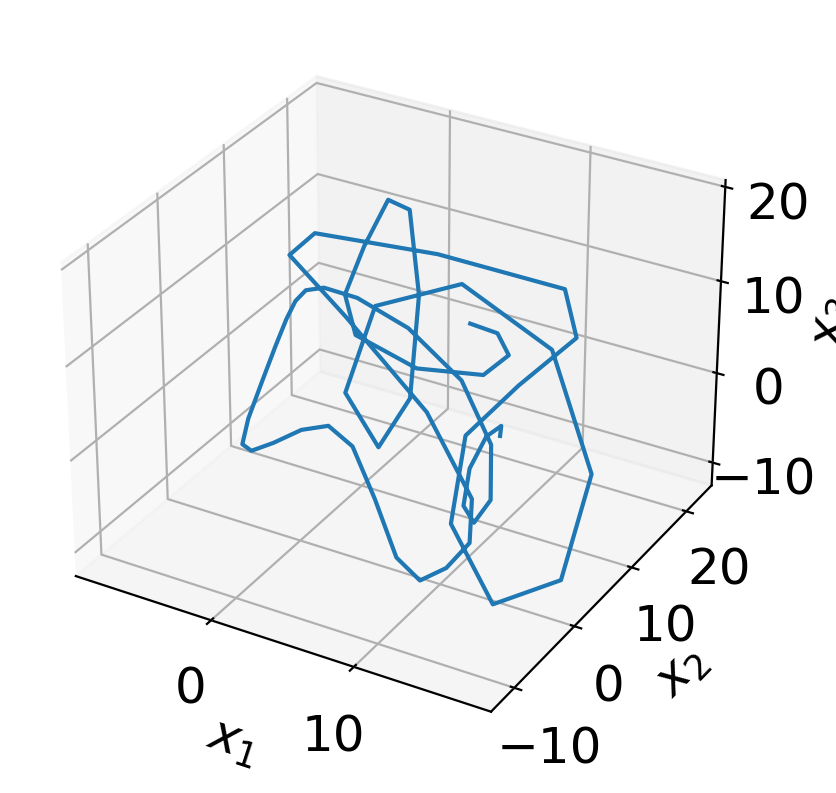

In [11]:
# Plot the first three variables
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(xs[:, 0], xs[:, 1], xs[:, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()

# The ensemble Kalman filter

## Classical example

>  There are indications that in nonlinear and nonGaussian systems the sampling based EnKF variants should be preferable over their square root counterparts

In [12]:
D = 100

In [13]:
N = 10 ** 4
dt = 0.05
x0 = jax.random.normal(key_init, (D,))
xs = jnp.zeros((N,) + x0.shape)
xs = xs.at[0].set(x0)
fpart = partial(f, D=D)
xs = rk4(xs, dt, N, fpart)
ys = xs + jax.random.normal(key_measurement, xs.shape)
# ys = xs + jax.random.t(key_measurement, df=2.01, shape=xs.shape)

In [14]:
range_time = np.arange(N) * dt

In [15]:
def callback_fn(particles, particles_pred, y, i):
    return jnp.sqrt(jnp.power(particles.mean(axis=0) - xs[i], 2).mean())

In [16]:
def latent_fn(x, key, i):
    """
    State function
    """
    err = jax.random.normal(key, (D,))
    @jax.jit
    def f(x, t):
        ixs = jnp.arange(D)
        return fcoord(x, ixs, D) + F + err
    
    return rk4_step(x, i, dt, f)


def obs_fn(x, key, i):
    """
    Measurement function
    """
    err = jax.random.normal(key, (D,))
    return x + err

In [17]:
n_particles = 1000
agent = enkf.EnsembleKalmanFilter(latent_fn, obs_fn, n_particles)

key_init_particles, key_scan = jax.random.split(key_eval, 2)

X0 = agent.init_bel(key_init_particles, D)
particles_end, errs = agent.scan(X0, key_scan, ys, callback_fn=callback_fn)

jnp.median(errs[100:])

Array(0.51394165, dtype=float32)

In [18]:
# Baseline error
jnp.mean(jnp.power(xs - ys, 2).mean(axis=1))

Array(0.999993, dtype=float32)

## Corrupted example

In [19]:
ys_corrupted = ys.copy()
p_err = 0.0001
errs_map = jax.random.bernoulli(key_init, p=p_err, shape=ys_corrupted.shape)
ys_corrupted = ys_corrupted * (~errs_map) + 100.0 * errs_map

In [20]:
(errs_map.any(axis=1)).mean()

Array(0.0109, dtype=float32)

In [21]:
p_err * D # Probability of a corruption per timestep

0.01

## WL EnEKF (soft)

In [22]:
agent = enkf.WLEnsembleKalmanFilterHard(latent_fn, obs_fn, n_particles, c=10.0)
n_particles = 1000
X0 = agent.init_bel(key_eval, D)

In [23]:
particles_end, errs_wenkf = agent.scan(X0, key_eval, ys_corrupted, callback_fn=callback_fn)

In [24]:
jnp.mean(errs_wenkf[100:])

Array(0.5169127, dtype=float32)

In [25]:
ix_init = 50
ix_end = 450
ix_steps = np.arange(ix_init, ix_end) * dt

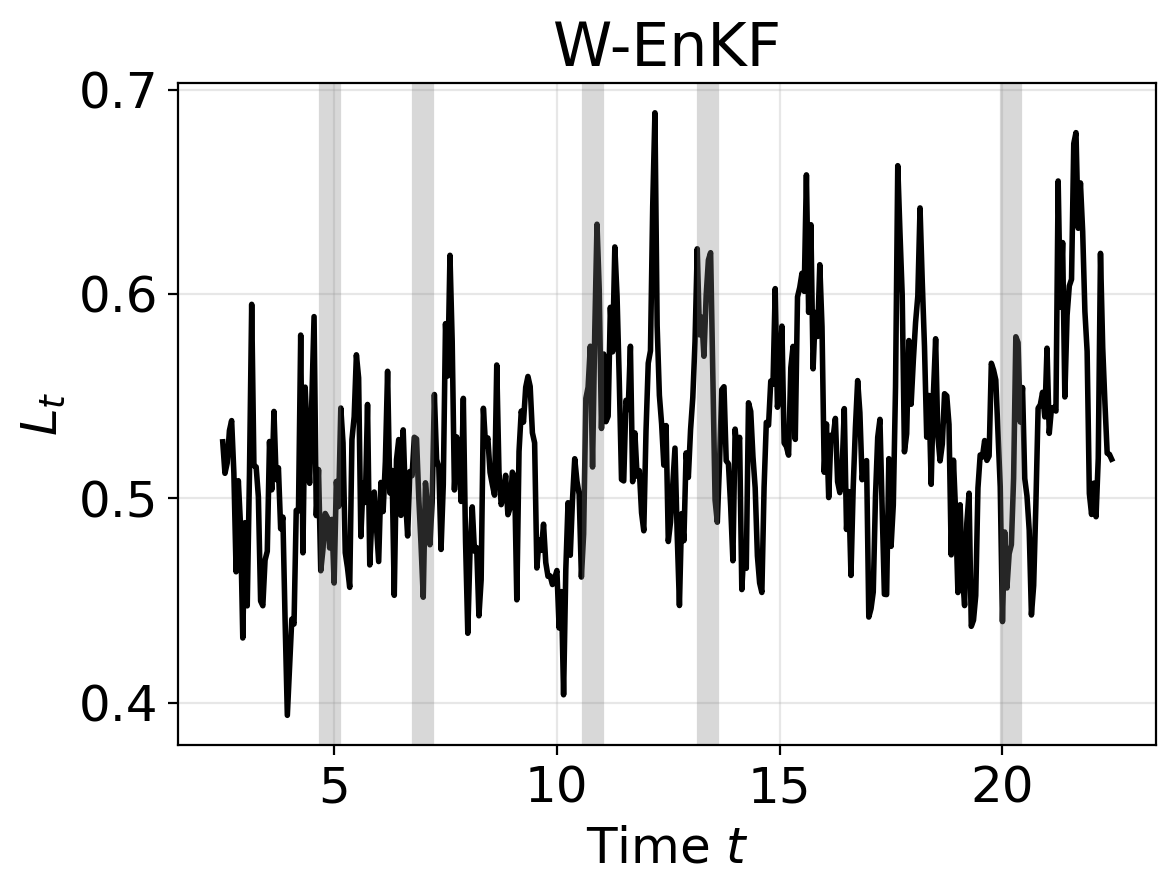

In [26]:
ixs_where, *_ = np.where(errs_map.any(axis=1)[ix_init:ix_end])

plt.plot(ix_steps, errs_wenkf[ix_init:ix_end], c="black", linewidth=2)
for ix in ixs_where:
    plt.axvline(x=ix_init * dt + ix * dt, c="tab:gray", alpha=0.3, linewidth=8)
plt.grid(alpha=0.3)
plt.xlabel("Time $t$")
plt.ylabel(r"$L_t$")
plt.title("W-EnKF")
plt.tight_layout()
plt.savefig("./figures/lorenz96-wlenkf-sample.png", dpi=300)

## Huberized EnEKF

In [27]:
agent = enkf.HubEnsembleKalmanFilter(latent_fn, obs_fn, n_particles, clipping_height=4.0)
n_particles = 1000
X0 = agent.init_bel(key_eval, D)

In [28]:
particles_end, errs_hubenkf = agent.scan(X0, key_eval, ys_corrupted, callback_fn=callback_fn)

In [29]:
jnp.mean(errs_hubenkf[100:])

Array(0.5172796, dtype=float32)

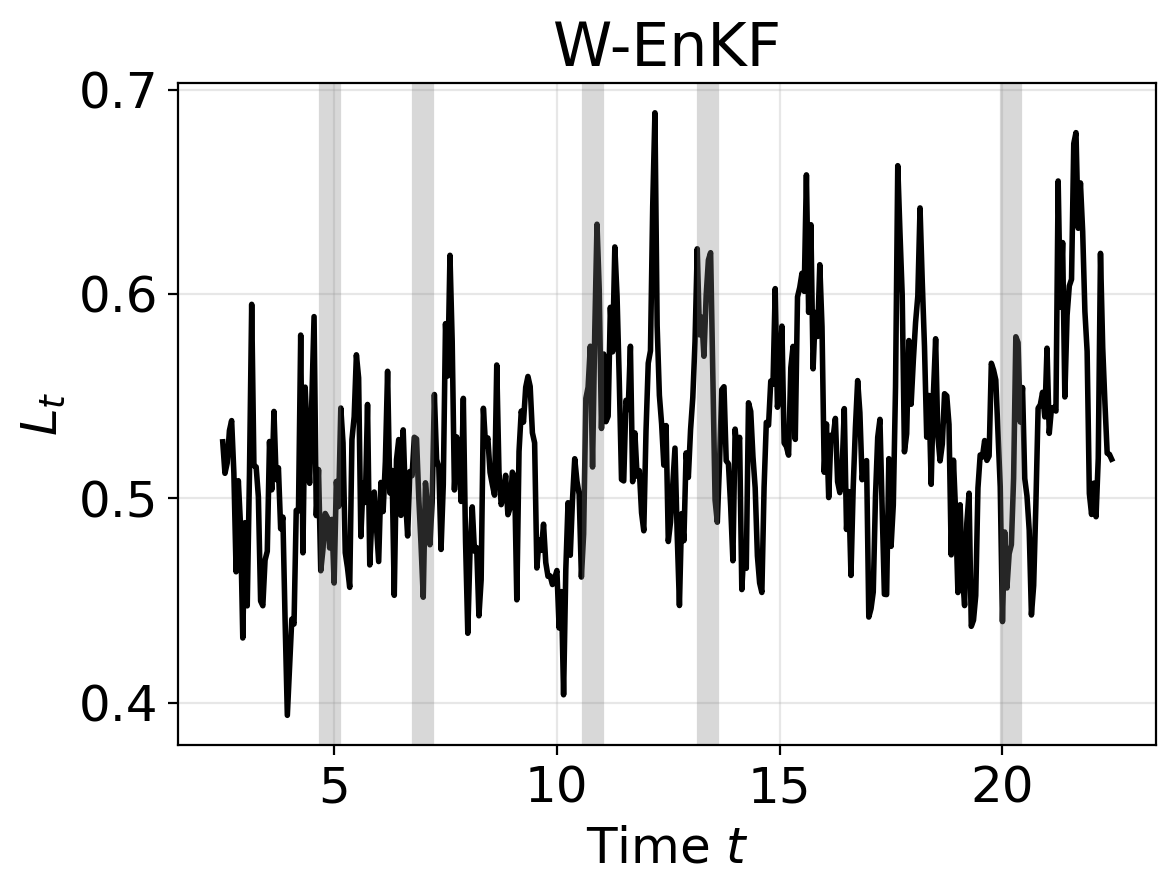

In [30]:
plt.plot(ix_steps, errs_wenkf[ix_init:ix_end], c="black", linewidth=2)
for ix in ixs_where:
    plt.axvline(x=ix_init * dt + ix * dt, c="tab:gray", alpha=0.3, linewidth=8)
plt.grid(alpha=0.3)
plt.xlabel("Time $t$")
plt.ylabel(r"$L_t$")
plt.title("W-EnKF")
plt.tight_layout()
plt.savefig("./figures/lorenz96-wlenkf-sample.png", dpi=300)

## Base EnEKF

In [31]:
agent = enkf.EnsembleKalmanFilter(latent_fn, obs_fn, n_particles)
n_particles = 1000
X0 = agent.init_bel(key_eval, D)

In [32]:
particles_end, errs_enkf = agent.scan(X0, key_eval, ys_corrupted, callback_fn=callback_fn)

In [33]:
jnp.mean(errs_enkf[100:])

Array(0.6833407, dtype=float32)

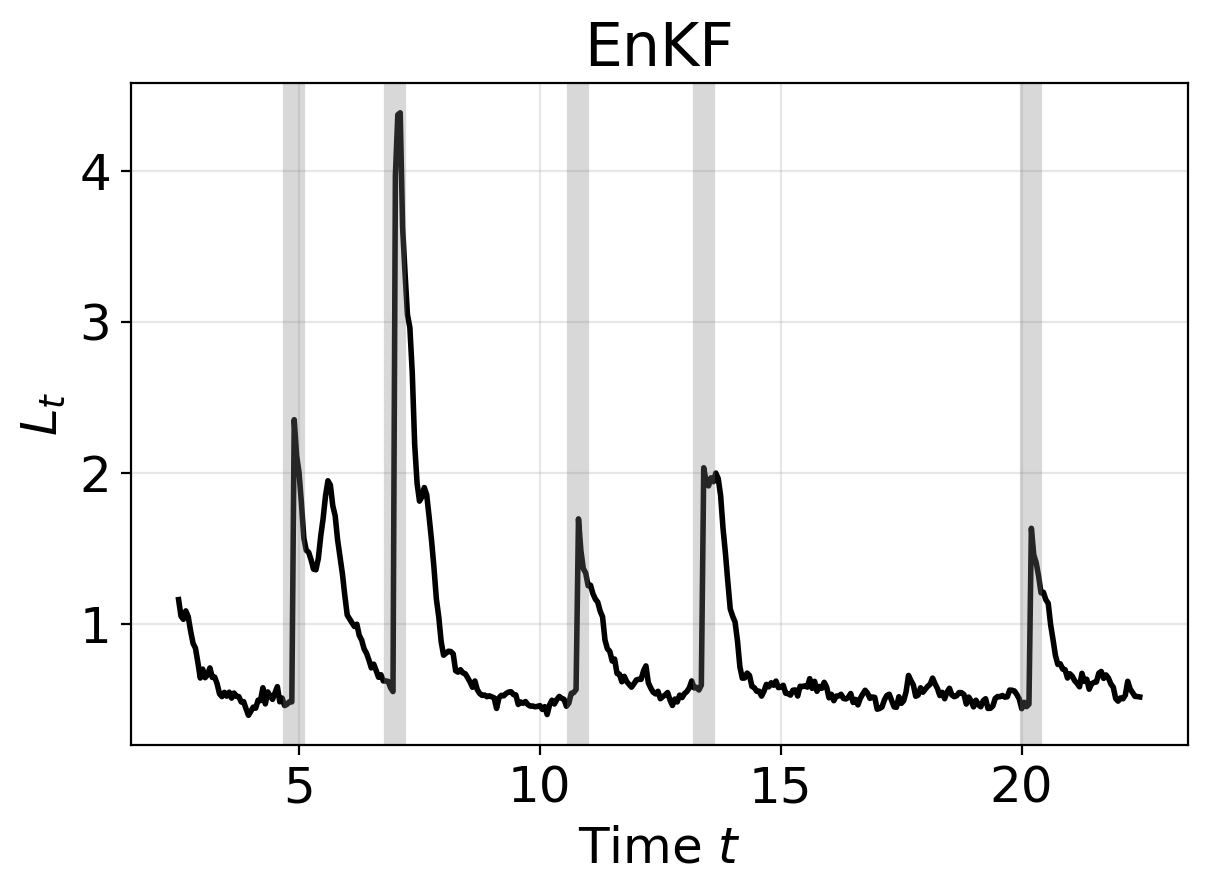

In [34]:
plt.plot(ix_steps, errs_enkf[ix_init:ix_end], c="black", linewidth=2)
for ix in ixs_where:
    plt.axvline(x=ix_init * dt + ix * dt, c="tab:gray", alpha=0.3, linewidth=8)
plt.grid(alpha=0.3)
plt.xlabel("Time $t$")
plt.ylabel(r"$L_t$")
plt.title("EnKF")
plt.tight_layout()
plt.savefig("./figures/lorenz96-enkf-sample.png", dpi=300)

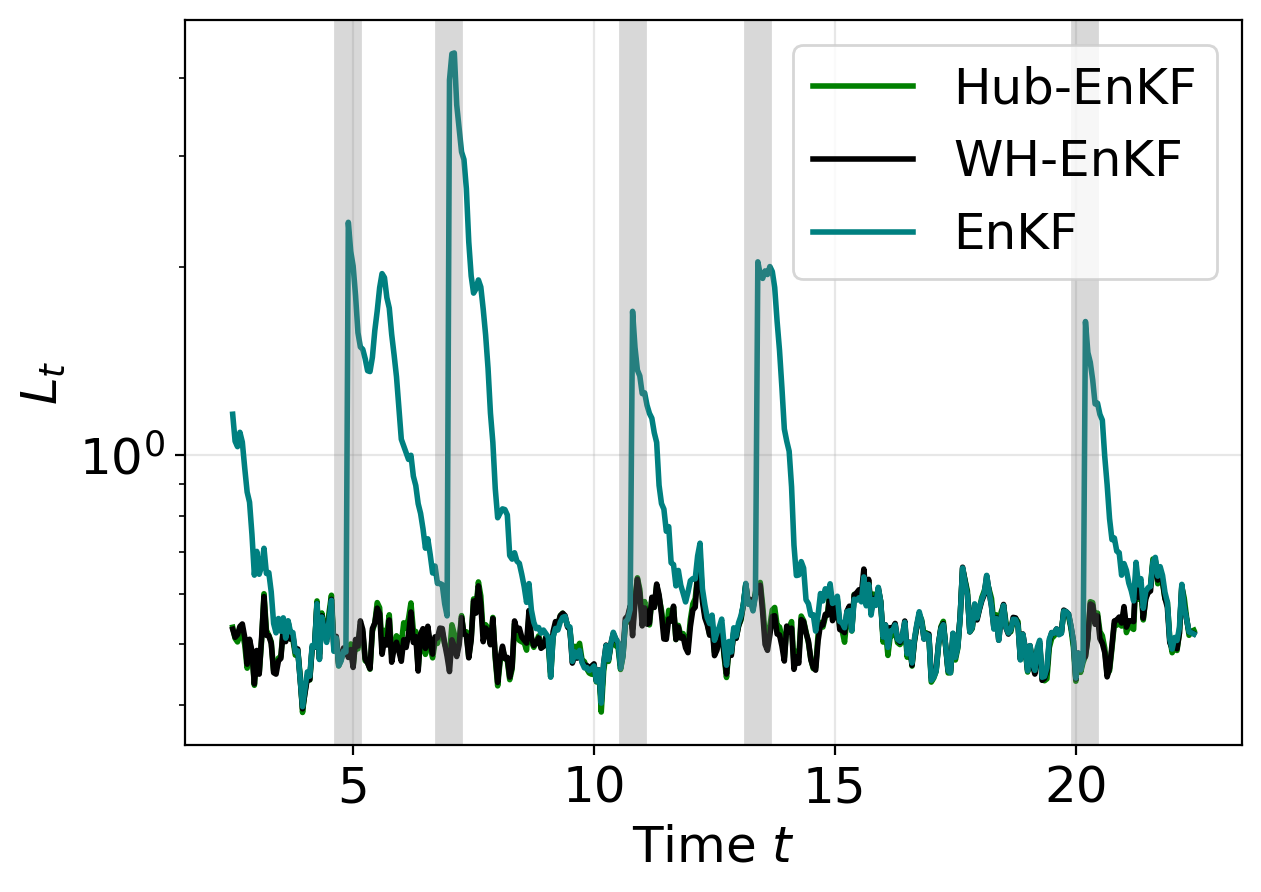

In [35]:
plt.plot(ix_steps, errs_hubenkf[ix_init:ix_end], c="green", linewidth=2, label="Hub-EnKF")
plt.plot(ix_steps, errs_wenkf[ix_init:ix_end], c="black", linewidth=2, label="WH-EnKF")
plt.plot(ix_steps, errs_enkf[ix_init:ix_end], c="teal", linewidth=2, label="EnKF")

for ix in ixs_where:
    plt.axvline(x=ix_init * dt + ix * dt, c="tab:gray", alpha=0.3, linewidth=10)
plt.grid(alpha=0.3)

plt.xlabel("Time $t$")
plt.ylabel(r"$L_t$")

plt.legend(loc="upper right")
plt.tight_layout()
plt.yscale("log")
plt.grid(alpha=0.3)
plt.savefig("./figures/lorenz96-wenkf-enkf-sample.png", dpi=300)

## Corrupted measurements

In [36]:
err_where = np.where(errs_map)

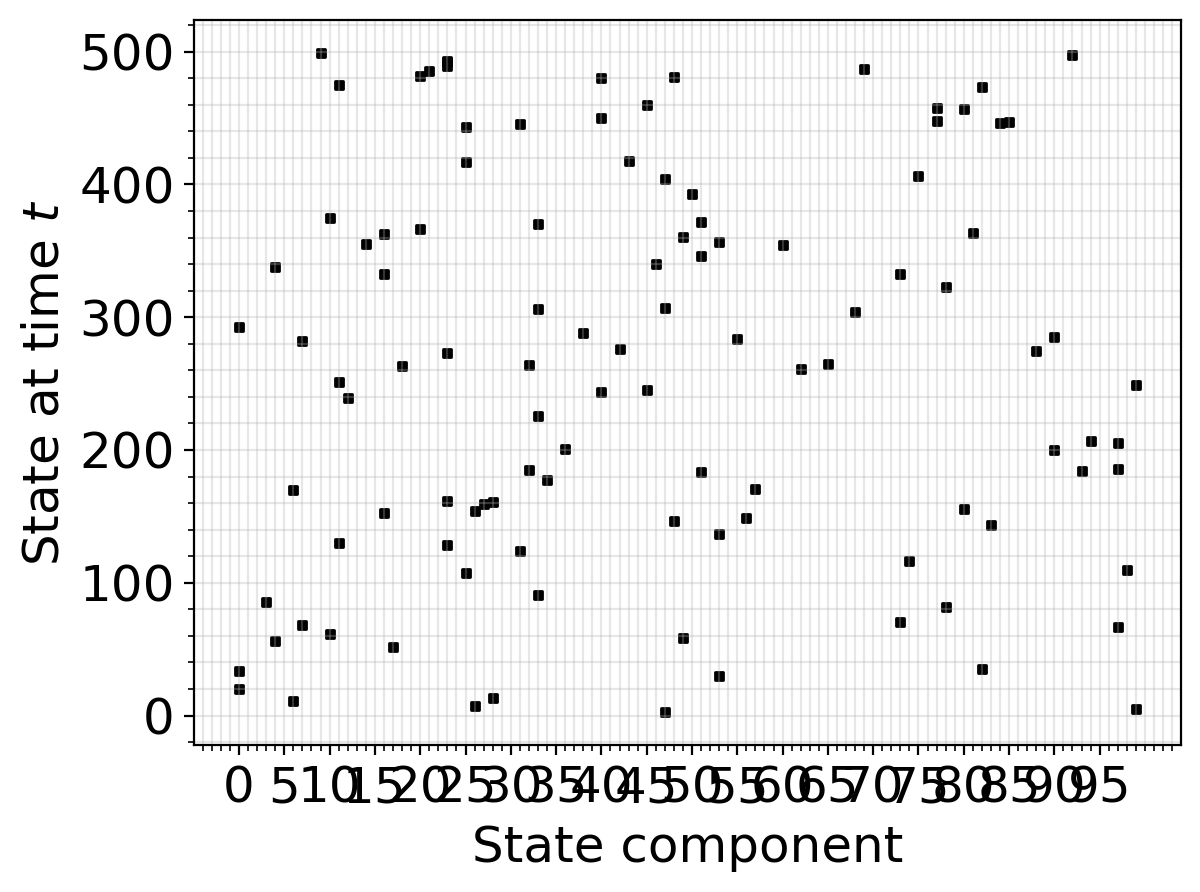

In [37]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots()
yerr, xerr = err_where
plt.scatter(xerr, yerr * dt, s=10, c="black", marker="s")
pos, _ = plt.xticks()
plt.xlabel("State component")
plt.ylabel("State at time $t$")
plt.tight_layout()

ax.set_xticks(np.arange(0, D, 5))

# Enable minor ticks on the x-axis
ax.minorticks_on()

# Set the number of minor ticks between major ticks
ax.xaxis.set_minor_locator(MultipleLocator(1))
plt.grid(alpha=0.3, zorder=0, which="both")
# plt.savefig("./figures/lorenz96-err-where.png", dpi=300)

In [38]:
# Proportion of timesteps in which at least one state component had an outlier value
errs_map.any(axis=1).mean()

Array(0.0109, dtype=float32)

In [39]:
errs_map.mean()

Array(0.000109, dtype=float32)

# Multiple runs
## The effect of the parameter $c$

In [40]:
def callback(particles, particles_pred, y, i, xs):
    return jnp.sqrt(jnp.power(particles.mean(axis=0) - xs[i], 2).mean())

In [41]:
p_err = 0.001
N = 10 ** 3
n_particles = 1000
p_err = 0.001
D = 100

@partial(jax.vmap, in_axes=(0, None, None))
def sample_corrupted_dataset(key, num_steps, dim_state):
    key_create, key_measurement, key_corrupt = jax.random.split(key, 3)
    
    x0 = jax.random.normal(key_create, (dim_state,))
    xs = jnp.zeros((num_steps,) + x0.shape)
    xs = xs.at[0].set(x0)
    fpart = partial(f, D=D)
    xs = rk4(xs, dt, num_steps, fpart)
    
    # ys_corrupted = xs + jax.random.t(key_measurement, df=2.01, shape=xs.shape)
        
    # ys_corrupted = xs + jax.random.normal(key_measurement, xs.shape)
    # errs_map = jax.random.bernoulli(key_corrupt, p=p_err, shape=ys_corrupted.shape)
    # ys_corrupted = ys_corrupted * (~errs_map) + 5 * ys_corrupted * errs_map
    
    ys_corrupted = xs + jax.random.normal(key_measurement, xs.shape)
    errs_map = jax.random.bernoulli(key_corrupt, p=p_err, shape=ys_corrupted.shape)
    ys_corrupted = ys_corrupted * (~errs_map) + 100 * errs_map

    
    return xs, ys_corrupted

@jax.jit
@partial(jax.vmap, in_axes=0)
def enkf_filter(key, ys_corrupted, xs):
    key_init, key_run = jax.random.split(key)
    
    agent = enkf.EnsembleKalmanFilter(latent_fn, obs_fn, n_particles)
    X0 = agent.init_bel(key_init, D)
    callback_fn = partial(callback, xs=xs)
    particles_end, errs = agent.scan(X0, key_run, ys_corrupted, callback_fn=callback_fn)

    return errs[100:].mean(axis=-1)


@jax.jit
@partial(jax.vmap, in_axes=(None, 0, 0, 0))
@partial(jax.vmap, in_axes=(0, None, None, None))
def wlenkf_filter(c, key, ys_corrupted, xs):
    key_init, key_run = jax.random.split(key)
    
    agent = enkf.WLEnsembleKalmanFilterHard(latent_fn, obs_fn, n_particles, c=c)
    X0 = agent.init_bel(key_init, D)
    callback_fn = partial(callback, xs=xs)
    particles_end, errs = agent.scan(X0, key_run, ys_corrupted, callback_fn=callback_fn)

    return errs[100:].mean(axis=-1)


@jax.jit
@partial(jax.vmap, in_axes=(None, 0, 0, 0))
@partial(jax.vmap, in_axes=(0, None, None, None))
def soft_wlenkf_filter(c, key, ys_corrupted, xs):
    key_init, key_run = jax.random.split(key)
    
    agent = enkf.WLEnsembleKalmanFilterSoft(latent_fn, obs_fn, n_particles, c=c)
    X0 = agent.init_bel(key_init, D)
    callback_fn = partial(callback, xs=xs)
    particles_end, errs = agent.scan(X0, key_run, ys_corrupted, callback_fn=callback_fn)

    return errs[100:].mean(axis=-1)



@jax.jit
@partial(jax.vmap, in_axes=(None, 0, 0, 0))
@partial(jax.vmap, in_axes=(0, None, None, None))
def hubenkf_filter(c, key, ys_corrupted, xs):
    key_init, key_run = jax.random.split(key, 2)
    
    agent = enkf.HubEnsembleKalmanFilter(latent_fn, obs_fn, n_particles, clipping_height=c)
    X0 = agent.init_bel(key_init, D)
    callback_fn = partial(callback, xs=xs)
    particles_end, errs = agent.scan(X0, key_run, ys_corrupted, callback_fn=callback_fn)

    return errs[100:].mean(axis=-1)

In [42]:
# c_values = jnp.linspace(3, 20, 8 * 3)
c_values = jnp.linspace(1, 20, 8 * 3)
sharding = jax.sharding.PositionalSharding(jax.devices())
c_values = jax.device_put(c_values, sharding)

In [43]:
n_trials = 20

key_sample, key_test = jax.random.split(key_eval)
keys_test = jax.random.split(key_test, n_trials)
keys_sample = jax.random.split(key_sample, n_trials)

## Sample data

In [44]:
xs, ys_corrupted = sample_corrupted_dataset(keys_test, N, D)

In [53]:
n_trials = 20
keys_eval = jax.random.split(key_eval, n_trials)

## EnKF

In [54]:
%%time
errs_enkf = enkf_filter(keys_eval, ys_corrupted, xs).block_until_ready()
errs_enkf = errs_enkf[~jnp.isnan(errs_enkf)]
errs_enkf.shape

CPU times: user 15.7 s, sys: 198 ms, total: 15.9 s
Wall time: 8.73 s


(14,)

In [55]:
# bootstrap results
nboot = 500
boot_enkf = pd.Series(errs_enkf)
boot = jnp.array([boot_enkf.sample(frac=1.0, replace=True, random_state=i).mean() for i in range(nboot)])

vmid = jnp.quantile(boot, 0.5)
vmin = jnp.quantile(boot, 0.05)
vmax = jnp.quantile(boot, 0.95)

In [56]:
vmid

Array(2.0827918, dtype=float32)

In [58]:
nboot = 500
errs_enkf_boot = jax.random.choice(key_eval, errs_enkf, shape=(nboot,))

vmid = errs_enkf_boot.mean(axis=0)
vmax = vmid + 1.96 * errs_enkf_boot.std(axis=0)
vmin = vmid - 1.96 * errs_enkf_boot.std(axis=0)

### WL-EnKF hard

In [59]:
%%time
errs_wlenkf = wlenkf_filter(c_values, keys_eval, ys_corrupted, xs).block_until_ready()

CPU times: user 16.3 s, sys: 242 ms, total: 16.6 s
Wall time: 46.7 s


In [60]:
err_mean_wlenkf = jnp.nanmean(errs_wlenkf, axis=0)
err_mean_wlenkf

Array([6.2990084 , 6.298164  , 6.2940774 , 6.016617  , 0.5194463 ,
       0.51614106, 0.5157565 , 0.5156904 , 0.5156904 , 0.5156904 ,
       0.5156904 , 0.5156904 , 0.5156904 , 0.5156904 , 0.5156904 ,
       0.5156904 , 0.5156904 , 0.5156904 , 0.5156904 , 0.5156904 ,
       0.5156904 , 0.5156904 , 0.5156904 , 0.5156904 ], dtype=float32)

### WL-EnKF soft

In [61]:
%%time
errs_wlenkf_soft = soft_wlenkf_filter(c_values, keys_eval, ys_corrupted, xs).block_until_ready()

CPU times: user 16.4 s, sys: 167 ms, total: 16.5 s
Wall time: 45.4 s


In [62]:
err_mean_wlenkf_soft = jnp.nanmean(errs_wlenkf_soft, axis=0)
err_mean_wlenkf_soft

Array([6.2808833 , 6.187425  , 5.917087  , 5.151894  , 2.1193044 ,
       0.54890573, 0.51590276, 0.51581013, 0.51568496, 0.5156664 ,
       0.51562184, 0.51563567, 0.51568836, 0.5156904 , 0.5156904 ,
       0.5156904 , 0.5156904 , 0.5156904 , 0.5156904 , 0.5156904 ,
       0.5156904 , 0.5156904 , 0.5156904 , 0.5156904 ], dtype=float32)

### Hub-EnKF

In [63]:
%%time
errs_hubenkf = hubenkf_filter(c_values, keys_eval, ys_corrupted, xs).block_until_ready()

CPU times: user 17.2 s, sys: 667 ms, total: 17.9 s
Wall time: 45.6 s


In [64]:
err_mean_hubenkf = jnp.nanmean(errs_hubenkf, axis=0)
err_mean_hubenkf

Array([1.4536221 , 0.5451212 , 0.52245843, 0.51924527, 0.5199428 ,
       0.5215684 , 0.5235319 , 0.5257355 , 0.5282593 , 0.5310546 ,
       0.5340961 , 0.53735703, 0.54115003, 0.5448646 , 0.5490143 ,
       0.5533515 , 0.55773354, 0.56293243, 0.56804526, 0.5736268 ,
       0.5787226 , 0.58492064, 0.590631  , 0.59745353], dtype=float32)

# Plot results

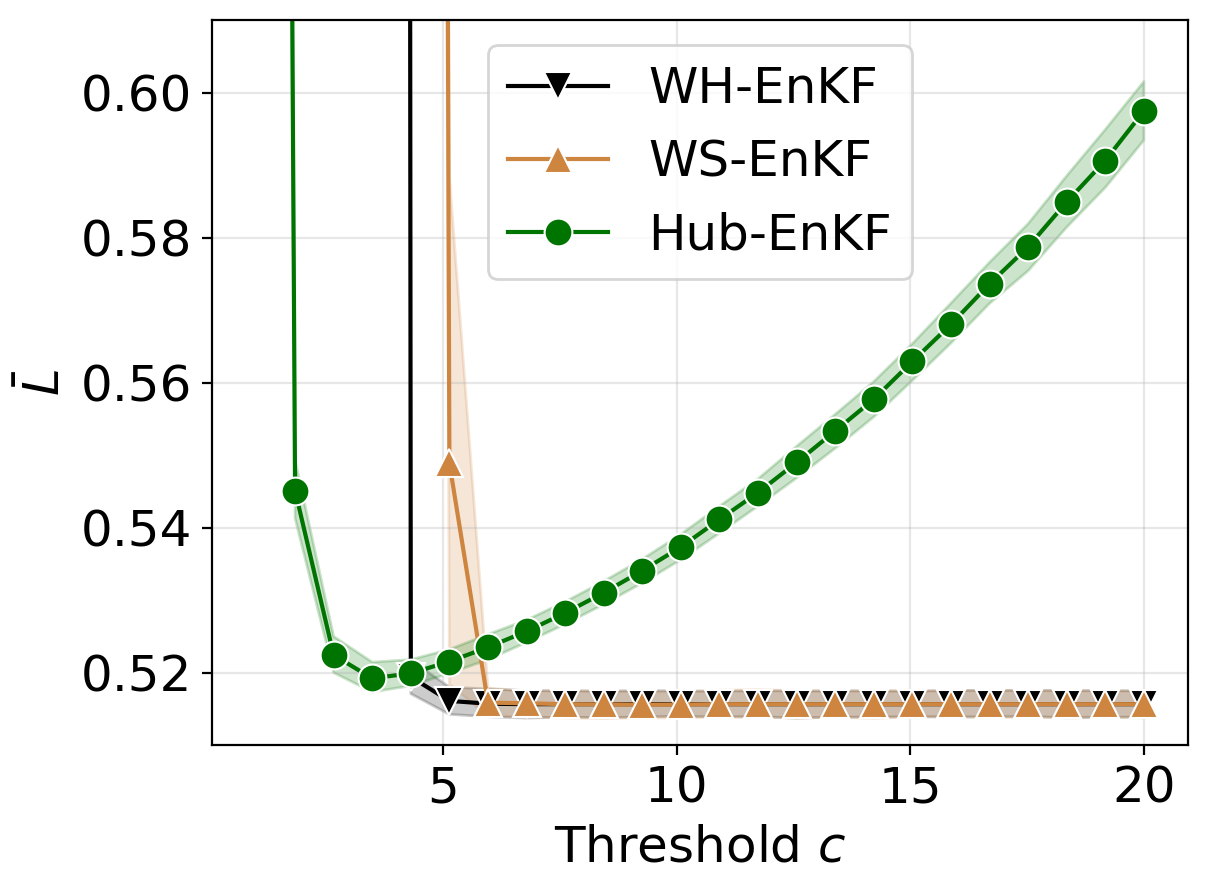

In [65]:

errs_df = pd.DataFrame(np.array(errs_wlenkf), columns=c_values)
sns.lineplot(
    x="variable",
    y="value",
    data=errs_df.melt(),
    color="black",
    marker="v",
    markersize=10,
    label="WH-EnKF"
)


errs_df = pd.DataFrame(np.array(errs_wlenkf_soft), columns=c_values)
sns.lineplot(
    x="variable",
    y="value",
    data=errs_df.melt(),
    color="peru",
    marker="^",
    markersize=10,
    label="WS-EnKF"
)


errs_df = pd.DataFrame(np.array(errs_hubenkf), columns=c_values)
sns.lineplot(
    x="variable",
    y="value",
    data=errs_df.melt(),
    color="#007400",
    marker="o",
    markersize=10,
    label="Hub-EnKF",
)


plot_enkf = False

if plot_enkf:
    plt.axhline(y=vmid, linestyle="--", linewidth=2, c="teal", label="EnKF")
    xmin, xmax = plt.xlim()
    xrange = np.linspace(xmin, xmax)
    plt.fill_between(xrange, vmin, vmax, color="teal", alpha=0.3)
    

# plt.xlim(xmin, xmax)

# plt.ylim(top=1.1)
# plt.ylim(top=0.5, bottom=0.43)
plt.ylim(bottom=0.51, top=0.61)

plt.legend(markerscale=1.0, ncol=1)
plt.xlabel("Threshold $c$")
plt.ylabel(r"$\bar{L}$")
plt.grid(alpha=0.3)
plt.tight_layout()
# plt.savefig("./figures/lorenz96-methods-benchmark.png", dpi=300)

## An animation

In [53]:
from matplotlib.animation import FuncAnimation

In [ ]:
snapshots = 150
N = 60 * snapshots
dt = 0.05
x0 = 8.0 + jax.random.normal(key_init, (D,))
xs = jnp.zeros((N,) + x0.shape)
xs = xs.at[0].set(x0)
xs = rk4(xs, dt, N, f)
ys = xs + jax.random.normal(key_measurement, xs.shape)
xs_cpu = np.array(xs)

In [ ]:
fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.7))
def anim(i):
    ax.cla()
    for n, row in enumerate(xs_cpu[i:i + 60][::-1]):
        ax.plot(
            (row - row.mean()) / row.std() + n * 0.4, c="black", linewidth=1.0, zorder=2,
            alpha = 1 - n / 60
        )
    ax.set_ylim(0, 59 * 0.4)
    ax.axis("off")
    plt.tight_layout()

animation = FuncAnimation(fig, anim, frames=snapshots)
animation.save("waves.gif", fps=10)

## ReweightedEnKF

In [375]:
p = 0.9
num_particles = 10
dim_state = 5
weights = jax.random.choice(key, 2, shape=(num_particles, dim_state), p=jnp.array([1 - p, p]))
particles = jax.random.normal(key_measurement, shape=(num_particles, dim_state))

In [376]:
resampled_particles = num_particles * dim_state - weights.sum()
p_weights = jnp.ones((num_particles, dim_state)) / resampled_particles
p_weights = p_weights.at[ix_where].set(0.0)

In [377]:
ix = 3
w = weights[:, ix]
w

Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [381]:
@jax.jit
@partial(jax.vmap, in_axes=(0, 1, 1), out_axes=1)
def resample_from_column(key, particles, weights):
    weights = 1 - weights
    p_weights = jnp.ones(num_particles) / (num_particles - weights.sum())
    
    rval = weights.argmax()
    ix_where = jnp.where(weights, size=num_particles, fill_value=rval)
    
    p_weights = p_weights.at[ix_where].set(0.0)

    particles_resample = jax.random.choice(key, particles, shape=(num_particles,), p=p_weights)
    
    return particles * (1 - weights) + particles_resample * weights

In [383]:
weights

Array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=int32)

In [384]:
part = particles[:, ix]
part

Array([0.24139011, 0.99619585, 0.27054146, 1.2113444 , 0.7780351 ,
       0.57123494, 0.05369573, 0.65138084, 0.12905332, 0.01989668],      dtype=float32)

In [385]:
particles[:, ix][jnp.where(w)[0][0]]

Array(0.24139011, dtype=float32)

In [386]:
jnp.where(w)[0]

Array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [387]:
p_weights = jnp.ones(num_particles) / (num_particles - w.sum())
jnp.where(w)[0]
p_weights = p_weights.at[jnp.where(w, size=num_particles, fill_value=0)].set(0.0)

In [388]:
p_weights

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [389]:
part_resample = jax.random.choice(key, part, shape=(num_particles,), p=p_weights)
part_resample

Array([0.24139011, 0.24139011, 0.24139011, 0.24139011, 0.24139011,
       0.24139011, 0.24139011, 0.24139011, 0.24139011, 0.24139011],      dtype=float32)

In [390]:
part * (1 - w) + part_resample * w

Array([0.24139011, 0.24139011, 0.24139011, 0.24139011, 0.24139011,
       0.24139011, 0.24139011, 0.24139011, 0.24139011, 0.24139011],      dtype=float32)